In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import torch
import os
import random

%matplotlib inline
from matplotlib import pyplot as plt

is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [2]:
def train_model(model, optimizer, X_train, X_train_lengths, Y_train, X_test, X_test_lengths, Y_test, epochs=500):
    X_train_padded = torch.nn.utils.rnn.pad_sequence(X_train, batch_first=True)
    max_length_train = X_train_padded.size(1)
    X_train_padded = X_train_padded.view(-1, max_length_train, 1)
    X_test_padded = torch.nn.utils.rnn.pad_sequence(X_test, batch_first=True)
    max_length_test = X_test_padded.size(1)
    X_test_padded = X_test_padded.view(-1, max_length_test, 1)
    train_accuracy = []
    test_accuracy = []
    train_batch_size = len(X_train_lengths)
    for i in range(epochs):
        params = list(model.named_parameters())
        model.zero_grad()
        hidden = model.init_hidden(train_batch_size).float()
        output = model(X_train_padded, hidden, X_train_lengths)
        # print(output, Y_train)
        loss = F.mse_loss(output, Y_train)
        loss.backward()
        optimizer.step()
        # for param_name, param in params:
        #    print(param_name, np.linalg.norm(param.grad.to("cpu").numpy()))
        optimizer.zero_grad()
        tr_accuracy = test_model(model, X_train, X_train_lengths, Y_train)
        train_accuracy.append(tr_accuracy)
        tst_accuracy = test_model(model, X_test, X_test_lengths, Y_test)
        test_accuracy.append(tst_accuracy)
    
    return model.eval(), train_accuracy, test_accuracy

In [3]:
def test_model(model, X_samp, X_samp_lengths, Y_samp):
    batch_size = len(X_samp_lengths)
    hidden = model.init_hidden(batch_size).float()
    X_samp_padded = torch.nn.utils.rnn.pad_sequence(X_samp, batch_first=True)
    max_length_samp = X_samp_padded.size(1)
    X_samp_padded = X_samp_padded.view(-1, max_length_samp, 1)
    output_test = model(X_samp_padded, hidden, X_samp_lengths)
    return F.mse_loss(output_test, Y_samp)

In [4]:
def evaluate_model(model, X_samp, X_samp_lengths, Y_samp):
    batch_size = len(X_samp_lengths)
    hidden = model.init_hidden(batch_size).float()
    X_samp_padded = torch.nn.utils.rnn.pad_sequence(X_samp, batch_first=True)
    max_length_samp = X_samp_padded.size(1)
    X_samp_padded = X_samp_padded.view(-1, max_length_samp, 1)
    output_test = model(X_samp_padded, hidden, X_samp_lengths)
    return output_test

In [5]:
class ModelOne(nn.Module):
    
    def __init__(self):
        super(ModelOne, self).__init__()
        self.rnn = nn.GRU(1, 128, 2, dropout=0.25, batch_first=True)
        self.dense = nn.Linear(128, 1)
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(2, batch_size, 128).to(device)

        return hidden
    
    def forward(self, x, hidden, x_lengths):
        batch_size = x.size(0)
        max_sequence_size = x.size(1)
        # hidden = self.init_hidden(batch_size).float()
        x = torch.nn.utils.rnn.pack_padded_sequence(x, x_lengths, batch_first=True)
        out, hidden = self.rnn(x, hidden)
        out, _ = torch.nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        out = out.contiguous()
        out = out.view(-1, 128)
        out = self.dense(out)
        out = out.view(batch_size, max_sequence_size, 1)
        
        indexes = torch.tensor(x_lengths) - 1
        out = out[torch.arange(batch_size), indexes, :]
        
        return out

In [6]:
model_one = ModelOne().to(device)

In [7]:
t = np.arange(0, 10, 0.1)

In [8]:
y = np.sin(t)

In [9]:
X = []
Y = []
freq = list(range(1, 19))

for i in freq:
    for n in range(10):
        limit = random.randint(5, 10)
        t = np.arange(0, limit, 0.1)
        x = np.sin(i * t)
        X.append(x[:-1])
        Y.append(x[-1])

In [10]:
XY = list(zip(X, Y))
random.shuffle(XY)
XY_train = XY[:int(0.8 * len(XY))]
XY_test = XY[int(0.8 * len(XY)):]
X_train = []
Y_train = []
X_test = []
Y_test = []
for x, y in XY_train:
    X_train.append(x)
    Y_train.append(y)

for x, y in XY_test:
    X_test.append(x)
    Y_test.append(y)

XY = None
XY_train = None
XY_test = None
X = None
Y = None

In [11]:
train_set = list(zip(X_train, Y_train))
train_set = sorted(train_set, key=lambda t: len(t[0]), reverse=True)
test_set = list(zip(X_test, Y_test))
test_set = sorted(test_set, key=lambda t: len(t[0]), reverse=True)

In [12]:
X_train = []
X_train_lengths = []
Y_train = []
X_test = []
X_test_lengths = []
Y_test = []
for x, y in train_set:
    X_train.append(torch.tensor(x).float().to(device))
    X_train_lengths.append(len(x))
    Y_train.append(torch.tensor(y))

Y_train = torch.tensor(Y_train).to(device)

for x, y in test_set:
    X_test.append(torch.tensor(x).float().to(device))
    X_test_lengths.append(len(x))
    Y_test.append(torch.tensor(y))

Y_test = torch.tensor(Y_test).to(device)
train_set = None
test_set = None

In [13]:
X_train_padded = torch.nn.utils.rnn.pad_sequence(X_train, batch_first=True)

In [14]:
X_train_padded.size()

torch.Size([144, 99])

In [15]:
train_batch_size = X_train_padded.size(0)
hidden = model_one.init_hidden(train_batch_size).float()

In [16]:
optimizer = optim.Adam(model_one.parameters(), lr=0.001)
model_one, train_accuracy, test_accuracy = train_model(model_one, optimizer, X_train, X_train_lengths, Y_train, X_test, X_test_lengths, Y_test, epochs=100)

/home/ubuntu/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Using a target size (torch.Size([144])) that is different to the input size (torch.Size([144, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/home/ubuntu/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Using a target size (torch.Size([144])) that is different to the input size (torch.Size([144, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  
/home/ubuntu/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Using a target size (torch.Size([36])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  


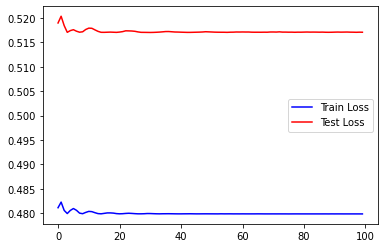

In [17]:
fig, ax = plt.subplots()
ax.plot(train_accuracy, "b-", label="Train Loss")
ax.plot(test_accuracy, "r-", label="Test Loss")
leg = ax.legend()

In [18]:
output_test = evaluate_model(model_one, X_test, X_test_lengths, Y_test)

In [19]:
output_test.size()

torch.Size([36, 1])

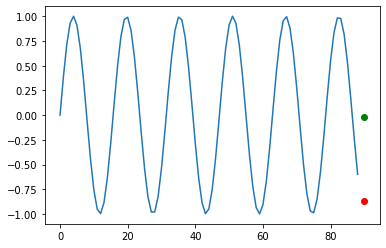

In [42]:
n = 5
plt.plot(X_test[n].to("cpu").numpy())
plt.plot(len(X_test[n]) + 1 ,output_test[n][0].to("cpu").detach().numpy(), "go")
plt.plot(len(X_test[n]) + 1, Y_test[n].to("cpu").numpy(), "ro")

In [23]:
output_test[0][0].to("cpu").detach().numpy()

array(-0.02387559, dtype=float32)

In [25]:
Y_test[0]

tensor(0.1839, device='cuda:0')

In [27]:
X_test[0][-1]

tensor(-0.4926, device='cuda:0')